In [3]:
from google.colab import drive

drive.mount('/content/drive')
datasheet = '/content/drive/My Drive/Datasheet/DDoS/dataset_sdn.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
df = pd.read_csv(datasheet)

In [5]:
#Mengecek info DataFrame
print('Info dari Datasheet\n')
df.info()

Info dari Datasheet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_

In [6]:
#Mengecek ukuran dataFrame (jumlah baris, jumlah kolom)
print('Jumlah baris dan Jumlah kolom datasheet ini:')
df.shape

Jumlah baris dan Jumlah kolom datasheet ini:


(104345, 23)

In [7]:
#Distribusi dari kolom label
df['label'].value_counts()

,count
label,
0,63561
1,40784


**PREPROCESSING**

In [10]:
print('Jumlah Missing Values')
print(df.isnull().sum())

Jumlah Missing Values
dt               0
switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        506
tot_kbps       506
label            0
dtype: int64


In [11]:
# Menghapus kolom bernilai null
df = df.dropna(subset=['rx_kbps','tot_kbps'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103839 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           103839 non-null  int64  
 1   switch       103839 non-null  int64  
 2   src          103839 non-null  object 
 3   dst          103839 non-null  object 
 4   pktcount     103839 non-null  int64  
 5   bytecount    103839 non-null  int64  
 6   dur          103839 non-null  int64  
 7   dur_nsec     103839 non-null  int64  
 8   tot_dur      103839 non-null  float64
 9   flows        103839 non-null  int64  
 10  packetins    103839 non-null  int64  
 11  pktperflow   103839 non-null  int64  
 12  byteperflow  103839 non-null  int64  
 13  pktrate      103839 non-null  int64  
 14  Pairflow     103839 non-null  int64  
 15  Protocol     103839 non-null  object 
 16  port_no      103839 non-null  int64  
 17  tx_bytes     103839 non-null  int64  
 18  rx_bytes     103839 non-null 

In [12]:
Features = ['dt','dur_nsec','tot_dur','pktrate','Protocol','port_no','tx_kbps','rx_kbps','tot_kbps']
df_feat = df[Features]

In [13]:
from sklearn.model_selection import train_test_split

X = df_feat
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2, random_state=42, stratify=y
)

In [15]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_features = ['dt','dur_nsec','tot_dur','pktrate','port_no','tx_kbps','rx_kbps','tot_kbps']
kateogrial_features = ['Protocol']

In [16]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder_cat = kateogrial_features
encoder_transform = encoder

In [17]:
scaler = StandardScaler()
numeric_feat = numeric_features
numeric_transform = scaler

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('cat',encoder_transform, encoder_cat),
        ('num',numeric_transform, numeric_feat)
    ],
    remainder='drop'
)

In [21]:
# Definisi base model
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    n_jobs= -1
)

In [22]:
rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', model_rf)
])

**HYPERPARAMETER TUNING (RandomSearchCV)**

In [24]:
from scipy.stats import randint

param_distributions = {
    'classifier__n_estimators': randint(100,200,300),
    'classifier__max_depth': randint(4, 5, 10),
    'classifier__min_samples_split': randint(2, 5, 10),
    'classifier__min_samples_leaf': randint(1, 3, 10),
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True,False]
}

In [26]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5 , shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_distributions,
    n_iter = 30,
    cv = cv,
    scoring = 'accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

In [27]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('cat',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['Protocol']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['dt',
                                                                                'dur_nsec',
                                                                                'tot_dur',
                                                                                'pktrate',
                                                                                'port_no',
                                                                                'tx_kbps',
                                                                                'rx_kbps',
                                                                                'tot_kbps'])])),
                                             ('classifier...
                                        'classifier__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e43f01e5130>,
                                        'classifier__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e43f020bc50>,
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e43effd9310>},
                   random_state=42, scoring='accuracy', verbose=2)

In [29]:
print('Best parameters', random_search.best_params_)
print('Best CV Score', random_search.best_score_)

Best parameters {'classifier__bootstrap': True, 'classifier__max_depth': 14, 'classifier__max_features': None, 'classifier__min_samples_leaf': 11, 'classifier__min_samples_split': 12, 'classifier__n_estimators': 499}
Best CV Score 0.9951968849913605


**EVALUATE MODEL**

In [31]:
best_model = random_search.best_estimator_

In [32]:
print(best_model)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Protocol']),
                                                 ('num', StandardScaler(),
                                                  ['dt', 'dur_nsec', 'tot_dur',
                                                   'pktrate', 'port_no',
                                                   'tx_kbps', 'rx_kbps',
                                                   'tot_kbps'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=14,
                                        max_features=None, min_samples_leaf=11,
                                        min_samples_split=12, n_estimators=499,
                                 

In [37]:
# Melakukan pengetasan performa model menggunakan data training agar diliat overfit atau tidaknya sebuah model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_train_pred = best_model.predict(X_train)
acc = accuracy_score(y_train,y_train_pred)
print(f"Training Accuracy:{acc:.4f}")

Training Accuracy:0.9968


In [41]:
# Melakukan pengujian performa menggunakan data pengujian
y_pred = best_model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print(f'Akurasi model dari data pengujian adalah: {acc_test:.4f}')
print(classification_report(y_test,y_pred))

Akurasi model dari data pengujian adalah: 0.9955
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     12667
           1       0.99      1.00      0.99      8101

    accuracy                           1.00     20768
   macro avg       0.99      1.00      1.00     20768
weighted avg       1.00      1.00      1.00     20768



In [42]:
# Korelasi fitur dengan label
# Jika korelasi lebih dari >0.95 pada fitur, maka terjadi leakage data (kebocoran data)

korelasi = df[Features + ['label']].select_dtypes(include=['number']).corr()['label'].sort_values(ascending=False)
print(korelasi)

label       1.000000
pktrate     0.089801
dur_nsec    0.029161
port_no    -0.002759
tx_kbps    -0.005646
rx_kbps    -0.006714
tot_kbps   -0.008748
tot_dur    -0.098745
dt         -0.108798
Name: label, dtype: float64


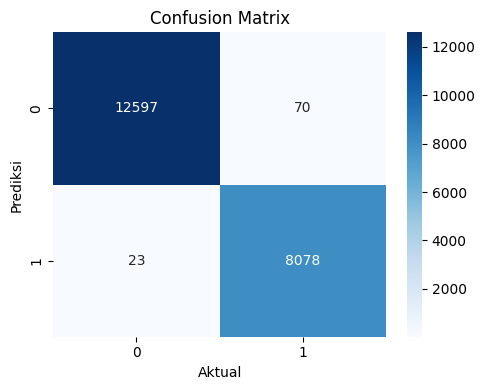

In [43]:
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, recall_score
)
import matplotlib.pyplot as plt
import seaborn as sns

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Aktual')
plt.ylabel('Prediksi')
plt.tight_layout()
plt.show()

In [47]:
#Evaluasi Model RandomForest
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
labels = ['Normal (0)','DDoS (1)']

print('=== Evaluasi Model ===')
print(f'Akurasi         : {accuracy:.4f}')
print(f'F1-Score Normal : {f1[0]:.4f}')
print(f'F1-Score DDoS   : {f1[1]:.4f}')
print(f'Recall Normal   : {recall[0]:.4f}')
print(f'Recall DDoS     : {recall[1]:.4f}')

=== Evaluasi Model ===
Akurasi         : 0.9955
F1-Score Normal : 0.9963
F1-Score DDoS   : 0.9943
Recall Normal   : 0.9945
Recall DDoS     : 0.9972


In [55]:
preprocessor  = best_model.named_steps['preprocess']
model = best_model.named_steps['classifier']

# Ambil nama fitur hasil transformasi OneHotEncoder & StandarScaler
feature_names = preprocessor.get_feature_names_out()

# Ambil Feature Importances dari Model (RandomForest)
importances = model.feature_importances_

print(f"Jumlah feature names: {len(feature_names)}")
print(f"Jumlah Importances : {len(importances)}")

Jumlah feature names: 11
Jumlah Importances : 11


In [57]:
# Gabungkan ke DataFrame
feat_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Tampilkan top 10 feature paling penting
print("\nTop 10 fitur penting RandomForest:")
print(feat_importance_df.head(10))


Top 10 fitur penting RandomForest:
               feature  importance
6         num__pktrate    0.585440
3              num__dt    0.142485
0   cat__Protocol_ICMP    0.140152
5         num__tot_dur    0.073434
1    cat__Protocol_TCP    0.030907
4        num__dur_nsec    0.018590
10       num__tot_kbps    0.006012
2    cat__Protocol_UDP    0.002455
9         num__rx_kbps    0.000241
8         num__tx_kbps    0.000197


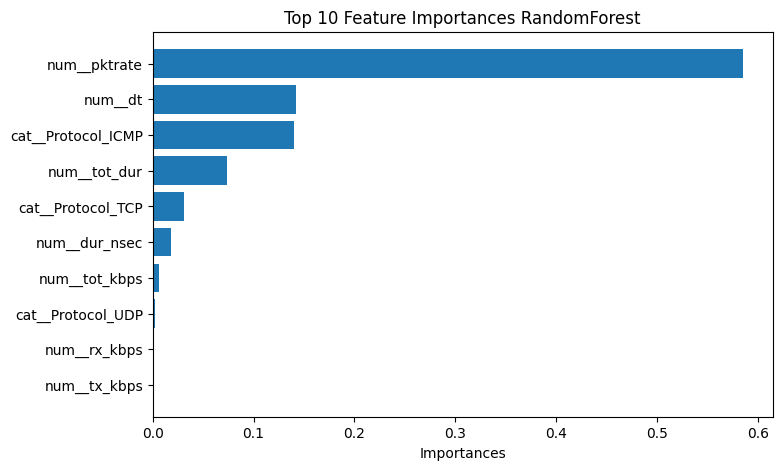

In [58]:
# Visualisasi
plt.figure(figsize=(8,5))
plt.barh(feat_importance_df['feature'][:10], feat_importance_df['importance'][:10])
plt.gca().invert_yaxis()
plt.xlabel('Importances')
plt.title('Top 10 Feature Importances RandomForest')
plt.show()

In [60]:
import joblib

joblib.dump(best_model, "ddos_detection_RF_Models.pkl")

from google.colab import files
files.download("ddos_detection_RF_Models.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>